<a href="https://colab.research.google.com/github/bangyuwen/stock-analysis/blob/main/treasury_stock_national_security_fund.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install


In [ ]:
%%capture
!pip install finlab > log.txt

In [ ]:
import pandas as pd
from finlab import data
import numpy as np
from datetime import datetime,timedelta
import finlab
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



## 庫藏股實施家數

In [ ]:
import pandas as pd
from finlab import data

預定買回期間_起	= data.get('treasury_stock:預定買回期間-起').unstack()
預定買回期間_迄	= data.get('treasury_stock:預定買回期間-迄').unstack()
# date 為董事會決議庫藏股日期
treasury_stock = pd.DataFrame({'預定買回期間_起':預定買回期間_起, '預定買回期間_迄':預定買回期間_迄}).dropna(how='all')
treasury_stock.index.names = ['stock_id', 'date']

# 產生實施期間序列
treasury_stock['period'] = [pd.date_range(s,e).to_list() for s,e in zip(treasury_stock['預定買回期間_起'],treasury_stock['預定買回期間_迄'])] 

# 使用 explode 展開資料
treasury_stock_period = treasury_stock.explode('period')
treasury_stock_period = treasury_stock_period[['period']]
treasury_stock_period

period
stock_id date                 
1101     2008-11-12 2008-11-13
         2008-11-12 2008-11-14
         2008-11-12 2008-11-15
         2008-11-12 2008-11-16
         2008-11-12 2008-11-17
...                        ...
9960     2005-11-03 2005-12-30
         2005-11-03 2005-12-31
         2005-11-03 2006-01-01
         2005-11-03 2006-01-02
         2005-11-03 2006-01-03

[310557 rows x 1 columns]

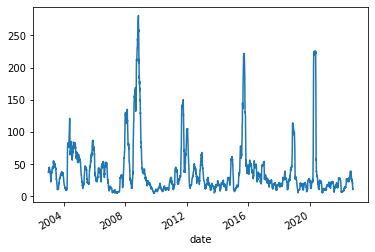

In [ ]:
# 計算每日預計實施庫藏股的公司家數
treasury_count = treasury_stock_period.groupby(['period'])['period'].count()
benchmark = data.get('benchmark_return:發行量加權股價報酬指數')

# 日期索引對應加權大盤報酬指數
treasury_count = treasury_count.reindex(benchmark.index).fillna(0)
treasury_count.plot()



## 國安基金資料整理

In [ ]:
df = data.get('national_security_fund')
national_security_fund = df.copy()
national_security_fund['退場時間'] = pd.to_datetime(national_security_fund['退場時間'].fillna(benchmark.index[-1]))
national_security_fund = national_security_fund[(national_security_fund['啟動時間']>=benchmark.index[0])]
national_security_fund

,項次,啟動時間,退場時間,時空背景,護盤金額(億)
2,3,2004-05-20,2004-06-01,總統大選與兩顆子彈,16.0
3,4,2008-09-18,2008-12-17,雷曼兄弟金融海嘯,599.0
4,5,2011-12-21,2012-04-20,歐債風暴,429.0
5,6,2015-08-25,2016-04-12,美國升息及全球經濟衰退疑慮,187.0
6,7,2020-03-20,2020-11-09,新冠疫情,75.6
7,8,2022-07-12,2022-10-14,通膨升息與俄烏戰爭,NaN


In [ ]:
df

,項次,啟動時間,退場時間,時空背景,護盤金額(億)
0,1,2000-03-16,2000-03-20,政黨輪替,542.0
1,2,2000-10-03,2000-11-15,停建核四,1227.0
2,3,2004-05-20,2004-06-01,總統大選與兩顆子彈,16.0
3,4,2008-09-18,2008-12-17,雷曼兄弟金融海嘯,599.0
4,5,2011-12-21,2012-04-20,歐債風暴,429.0
5,6,2015-08-25,2016-04-12,美國升息及全球經濟衰退疑慮,187.0
6,7,2020-03-20,2020-11-09,新冠疫情,75.6
7,8,2022-07-12,NaT,通膨升息與俄烏戰爭,NaN


## 繪圖

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(x=treasury_count.index, y=treasury_count.values, marker_color='navy',name="庫藏股實施家數"),
    secondary_y=False,
)

fig.update_traces(marker_color = 'rgba(0,0,250, 0.5)',
                  marker_line_width = 0,
                  selector=dict(type="bar"))

# 大盤指數
fig.add_trace(
    go.Scatter(x=benchmark.index, y=benchmark['發行量加權股價報酬指數'],line = dict(color = '#2C191B'), name="發行量加權股價報酬指數"),
    secondary_y=True,
)

# 國安基金實施期間
for i,row in national_security_fund.iterrows():
    fig.add_vrect(x0=row['啟動時間'], x1=row['退場時間'], 
                  annotation_text=row['時空背景'], annotation_position="top left",
                  fillcolor="green", opacity=0.25, line_width=0)
    
# Add figure title
fig.update_layout(
        height = 800,
        title={
            'text': "庫藏股與國安基金護盤趨勢",
            'x': 0.49,
            'y': 0.9,
            'xanchor': 'center',
            'yanchor': 'top'},
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=0.3
        )
)

# Set x-axis title
fig.update_xaxes(title_text="date",
                 rangeselector=dict(
                     buttons=list([
                         dict(count=1,
                              label="1y",
                              step="year",
                              stepmode="backward"),
                         dict(count=3,
                              label="3y",
                              step="year",
                              stepmode="backward"),
                         dict(count=5,
                              label="5y",
                              step="year",
                              stepmode="backward"),
                         dict(count=10,
                              label="10y",
                              step="year",
                              stepmode="backward"),
                         dict(step="all")
                     ])
                 ),
                 rangeslider=dict(
                     visible=True
                 ),
                 type="date")



# Set y-axes titles
fig.update_yaxes(title_text="<b>count</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>benchmark</b>", secondary_y=True,showgrid=False)
fig.show()